In [ ]:
# MIT License
#
# Copyright (c) 2020 Fagner Cunha
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transferência de Aprendizado com TensorFlow

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/alcunha/nn-with-tf/blob/master/Transfer-Learning-with-TF.ipynb"><img src="./images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/alcunha/nn-with-tf/blob/master/Transfer-Learning-with-TF.ipynb"><img src="./images/GitHub-Mark-32px.png" />Ver código no GitHub</a>
  </td>
</table>

*“NÃO ENTRE EM PÂNICO”*

(O Guia do Mochileiro das Galáxias)

In [ ]:
! pip install tensorflow matplotlib pillow

In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

## Transferência de aprendizado

Para a maioria dos problemas reais, as bases de dados não são grandes o suficiente para treinar modelos de aprendizado profundo e não é prático ou viável adquirir novas instâncias. Para esses casos, costuma-se utilizar uma técnica chamada Transferência de aprendizado que consiste em utilizar um modelo pré-treinado em problema similar e adaptar para o problema alvo.

Há várias formas de se aplicar transferência de aprendizado com deep learning. Uma das mais comuns é utilizar um modelo pré-treinado como extrator de características. Para fazer isso, remove-se a última camada do modelo e substitui-se por uma nova camada de acordo com o problema alvo. Os demais pesos do modelo original são congelados e somente a última camada é treinada. A Figura 1 exemplifica esse procedimento para um problema hipotético de classificação de animais onde o modelo original foi treinado para reconhecer animais da África e o problema alvo é reconhecer animais da Amazônia.

<img src="./images/transfer_learning.png" width="600">
<center>Figura 1: Esquema exemplificando transferência de aprendizado utilizando modelo pré-treinado como extrator de características</center>
<center>Fonte: Elaborado pelo autor</center>

## Exemplo Prático: Transferência de aprendizado para o dataset Dogs and Cats

1. Utilização do ImageDataGenerator
2. Construção do modelo
3. Treinamento
4. Avaliação do modelo e visualização dos resultados

#### Carregamento do dataset e visualização dos dados

In [2]:
CATS_DOGS_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_path = keras.utils.get_file('cats_and_dogs.zip', origin=CATS_DOGS_URL, extract=True)
dataset_path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')

In [3]:
train_path

'/home/fagner/.keras/datasets/cats_and_dogs_filtered/train'

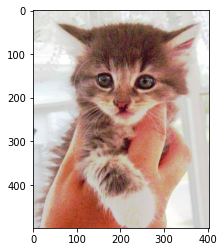

In [4]:
plt.imshow(keras.preprocessing.image.load_img(
    os.path.join(train_path, 'cats/cat.100.jpg')))

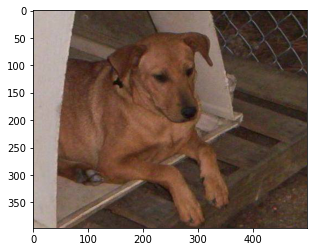

In [5]:
plt.imshow(keras.preprocessing.image.load_img(
    os.path.join(train_path, 'dogs/dog.100.jpg')))

In [6]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10

### Utilização do ImageDataGenerator e aumento de dados

In [7]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   rescale=1. / 255,
                                   fill_mode="nearest")

In [8]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

Found 2000 images belonging to 2 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [11]:
images, labels = next(train_generator)

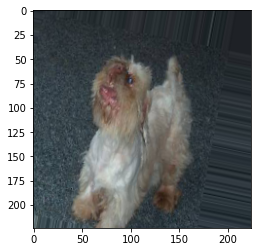

In [12]:
plt.imshow(images[4])

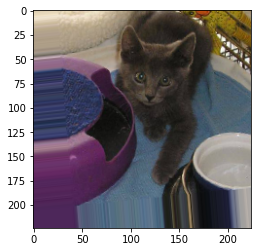

In [13]:
plt.imshow(images[15])

### Construção do modelo

Os pesos não serão congelados

In [14]:
base_model = MobileNetV2(input_shape=(224,225,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [15]:
for layer in model.layers:
    layer.trainable = True

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Treinamento

In [17]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=validation_generator.n // EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
62/62 [==============================] - 22s 361ms/step - loss: 0.2912 - accuracy: 0.8816 - val_loss: 0.8057 - val_accuracy: 0.8900
Epoch 2/10
62/62 [==============================] - 21s 345ms/step - loss: 0.1490 - accuracy: 0.9395 - val_loss: 3.7517 - val_accuracy: 0.7660
Epoch 3/10
62/62 [==============================] - 21s 343ms/step - loss: 0.1230 - accuracy: 0.9553 - val_loss: 0.9347 - val_accuracy: 0.9200
Epoch 4/10
62/62 [==============================] - 21s 342ms/step - loss: 0.1321 - accuracy: 0.9522 - val_loss: 0.6566 - val_accuracy: 0.9210
Epoch 5/10
62/62 [==============================] - 21s 339ms/step - loss: 0.1047 - accuracy: 0.9548 - val_loss: 1.2473 - val_accuracy: 0.8530
Epoch 6/10
62/62 [==============================] - 21s 344ms/step - loss: 0.0963 - accuracy: 0.9619 - val_loss: 3.7922 - val_accuracy: 0.7100
Epoch 7/10
62/62 [==============================] - 21s 342ms/step

### Visualização dos resultados

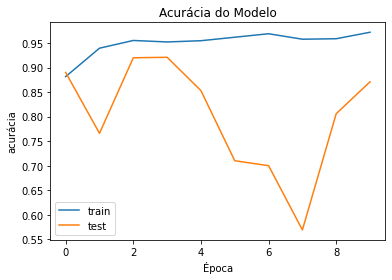

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

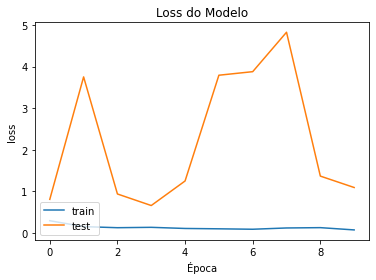

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()